<center><h1>In the name of Allah</h1></center>

Name: Amirhossein Alamdar

Student Number: 400105144

In this notebook, you will explore adversarial attacks and training methods in deep learning. First, you will train a simple model, ResNet18, on the CIFAR-10 dataset. Next, you will learn about two different adversarial attacks: FGSM (Fast Gradient Sign Method) and PGD (Projected Gradient Descent). To enhance your understanding, you will implement the PGD attack from scratch, while the FGSM attack will be implemented using a library. After this, you will use the FGSM attack to generate adversarial examples and then perform adversarial training on the model using the CIFAR-10 dataset. Finally, you will compare the performance and robustness of the adversarially trained model with the original model. 

Good luck!

## outline
- Train Resnet on CIFAR10
- FGSM Attack using torchattacks
- PGD Attack from scratch
- Visualization
- Adversarial Training


In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.autograd import Variable
from tqdm import tqdm

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


## Train Resnet on CIFAR10 (15 pts)

In [3]:
# Prepare Cifar10 data
import torch.utils
import torch.utils.data


batch_size = 128
transform = transforms.Compose([transforms.ToTensor(),])

##############################################################################
# Prepare training and test datasets and dataloaders                         #
##############################################################################
trainset = torchvision.datasets.CIFAR10('./CIFAR10', train=True, transform=transform, download=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10('./CIFAR10', train=False, transform=transform, download=True)
testloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=False) 
################################ End #########################################

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# model architecture
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

class resnet(nn.Module):
  def __init__(self, num_cls):
    super().__init__()
    self.conv = nn.Sequential(*list(resnet18(weights=None).children())[:-2])
    self.fc = nn.Linear(512, num_cls)

  def forward(self, x):
    x = self.conv(x)
    x = torch.flatten(x, start_dim=1)
    logits = self.fc(x)
    return logits

##############################################################################
# Initialize model and move to device                                        #
##############################################################################
model = resnet(len(classes))
model.to(device)

################################ End #########################################

resnet(
  (conv): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

In [5]:
learning_rate = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
epochs = 80

In [6]:
##############################################################################
# Implement train loop and log training loss after each epoch                #
##############################################################################

for _ in range(epochs):
    train_loss = 0
    num_iters = 0
    for data, label in trainloader:
        data, label = data.to(device), label.to(device)

        output = model(data)
        loss = criterion(output, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.detach().item()
        num_iters += 1

    print(f'epoch: {_}, loss: {train_loss/num_iters}')    
    


################################ End #########################################

epoch: 0, loss: 1.5302341783138187
epoch: 1, loss: 1.1291979665646468
epoch: 2, loss: 0.9226096519423873
epoch: 3, loss: 0.7730035865703202
epoch: 4, loss: 0.6542772414434291
epoch: 5, loss: 0.5518973600071715
epoch: 6, loss: 0.45398086991608905
epoch: 7, loss: 0.3730428329361674
epoch: 8, loss: 0.3101791536716549
epoch: 9, loss: 0.26325721545216374
epoch: 10, loss: 0.21106387867265955
epoch: 11, loss: 0.1662124075814891
epoch: 12, loss: 0.1415507543517653
epoch: 13, loss: 0.11599056313619437
epoch: 14, loss: 0.11162534195577245
epoch: 15, loss: 0.08581792534140827
epoch: 16, loss: 0.0715602617091535
epoch: 17, loss: 0.07424782896104752
epoch: 18, loss: 0.06619432687168689
epoch: 19, loss: 0.05503683158046449
epoch: 20, loss: 0.04912402026017037
epoch: 21, loss: 0.04923690108063124
epoch: 22, loss: 0.03740800326794881
epoch: 23, loss: 0.034296537173645156
epoch: 24, loss: 0.03131460471321707
epoch: 25, loss: 0.031740561236634546
epoch: 26, loss: 0.03294268153879382
epoch: 27, loss: 0.0

In [7]:
##############################################################################
# Evaluate the trained model on test set and print test accuracy             #
##############################################################################
torch.cuda.empty_cache()
from sklearn.metrics import accuracy_score

model.eval()
with torch.no_grad():
    test_loss = 0
    correct = 0
    num_iters = 0

    for data, label in testloader:
        data, label = data.to(device), label.to(device)
        output = model(data)
        loss = criterion(output, label)

        test_loss += loss.item()
        num_iters += 1
        pred = torch.argmax(output, dim=-1)
        print(pred.shape, label.shape)
        correct += (pred == label).sum().item()

    accuracy = correct / len(testloader.dataset)
    avg_loss = test_loss / num_iters

    print(f'accuracy: {accuracy:.4f}, loss: {avg_loss:.4f}')




################################ End #########################################

accuracy: 0.9999600052833557, loss: 0.00018671170584308883


In [8]:
# Save model
model.eval()
model_name = "./models/resnet18_cifar10_model_pretrained.pth"
model_PATH = f"{model_name}"
torch.save(model.state_dict(), model_PATH)

## FGSM Attack using torchattacks (10 pts)

In this section you should run FGSM attack using torchattacks library (https://adversarial-attacks-pytorch.readthedocs.io/en/latest/index.html).

Run the attack for $\epsilon \in \{\frac{1}{255}, \frac{4}{255}, \frac{8}{255},\}$ report the performance of the model on untargeted FGSM attack on the test data.

In [9]:
##############################################################################
# run untargeted FGSM attack for epsilon = 1/255 and report its accuracy     #
##############################################################################
import torchattacks

attack = torchattacks.FGSM(model, eps=1/255)
model.eval()

true = 0
for images, labels in testloader:
    images, labels = images.to(device), labels.to(device)
    adv_images = attack(images, labels)

    with torch.no_grad():
        output = model(adv_images)   
        pred = torch.argmax(output, dim = -1)
        true += torch.sum((pred.detach().cpu() == labels.detach().cpu()).to(int))     

print(f'acc: {true/len(testloader.dataset)}')


################################ End #########################################

acc: 0.963100016117096


In [10]:
##############################################################################
# run untargeted FGSM attack for epsilon = 4/255 and report its accuracy     #
##############################################################################



attack = torchattacks.FGSM(model, eps=4/255)
model.eval()

true = 0
for images, labels in testloader:
    images, labels = images.to(device), labels.to(device)
    adv_images = attack(images, labels)

    with torch.no_grad():
        output = model(adv_images)   
        pred = torch.argmax(output, dim = -1)
        true += torch.sum((pred.detach().cpu() == labels.detach().cpu()).to(int))     

print(f'acc: {true/len(testloader.dataset)}')

################################ End #########################################

acc: 0.4053800106048584


In [11]:
##############################################################################
# run untargeted FGSM attack for epsilon = 8/255 and report its accuracy     #
##############################################################################


attack = torchattacks.FGSM(model, eps=8/255)
model.eval()

true = 0
for images, labels in testloader:
    images, labels = images.to(device), labels.to(device)
    adv_images = attack(images, labels)

    with torch.no_grad():
        output = model(adv_images)   
        pred = torch.argmax(output, dim = -1)
        true += torch.sum((pred.detach().cpu() == labels.detach().cpu()).to(int))     

print(f'acc: {true/len(testloader.dataset)}')


################################ End #########################################

acc: 0.17260000109672546


## PGD Attack from scratch (30 pts)

In this section you should implement PGD attack from scratch.

In [12]:
model = resnet(len(classes))
model.load_state_dict(torch.load('./models/resnet18_cifar10_model_pretrained.pth'))

<All keys matched successfully>

In [13]:
import torch.nn.functional as F

class LinfPGDAttack(object):

    def __init__(self, model, epsilon=8/255, k=2, alpha=2/255):
        self.model = model
        self.epsilon = epsilon
        self.steps = k
        self.alpha = alpha

    def __call__(self, images, labels):
        images = images.to(device)
        labels = labels.to(device)

        perturbed_images = images.clone().detach()
        perturbed_images = perturbed_images.to(device)

        for idx in range(len(images)):
            image = images[idx:idx+1] 
            label = labels[idx:idx+1]

            out = self.model(image)
            _, pred = torch.max(out, 1)

            if pred.item() == label.item():
                ##############################################################################
                # Implement a k step PGD attack of size alpha                                #
                # while always staying within epsilon distance from the initial point        #
                # Use cross entropy loss                                                     #
                ##############################################################################
                perturbed_image = image.clone().detach()
                perturbed_image = perturbed_image.to(device)
                perturbed_image.requires_grad = True

                for _ in range(self.steps):
                    self.model.zero_grad()

                    outputs = self.model(perturbed_image)
                    loss = F.cross_entropy(outputs, label)

                    loss.backward()
                    sign_data_grad = perturbed_image.grad.data.sign()
                    perturbed_image = perturbed_image + self.alpha * sign_data_grad

                    perturbed_image = torch.clamp(perturbed_image, image - self.epsilon, image + self.epsilon)

                    perturbed_image = torch.clamp(perturbed_image, 0, 1)
                    perturbed_image = perturbed_image.detach()
                    perturbed_image.requires_grad = True
                ################################ End #########################################

                perturbed_image = perturbed_image.detach()  
                perturbed_images[idx:idx+1] = perturbed_image 

        return perturbed_images


In [14]:
##############################################################################
# Evaluate PGD attack on the trained model with k=2,4,8                      #
##############################################################################
model = resnet(len(classes))
model.load_state_dict(torch.load('./models/resnet18_cifar10_model_pretrained.pth'))

batch_num = 10
k_list = [2,4,8]
device = 'cuda:0'
##############################################################################
for kk in k_list:
    attack = LinfPGDAttack(model, k = kk)
    model.to(device)
    model.eval()

    true = 0
    cnt = 0
    for images, labels in testloader:
        cnt += 1
        images, labels = images.to(device), labels.to(device)
        adv_images = attack(images, labels)

        with torch.no_grad():
            output = model(adv_images)   
            pred = torch.argmax(output, dim = -1)
            true += torch.sum((pred.detach().cpu() == labels.detach().cpu()).to(int))     
        if cnt == batch_num:
            break
    print(f'k: {kk}, acc: {true/(10 * batch_size)}')
    
################################ End #########################################

k: 2, acc: 0.2640624940395355
k: 4, acc: 0.03828125074505806
k: 8, acc: 0.010937499813735485


## Visualization (10 pts)

Implement a function to plot the original image, the perturbed image and their predicted labels by the model

In [15]:
##############################################################################
# Implement the function described                                           #
##############################################################################
import matplotlib.pyplot as plt

def plot_images_with_predictions(original_image, adv_image, original_label, adv_label):

    fig, axes = plt.subplots(1, 2, figsize=(3, 2))
    
    axes[0].imshow(original_image.permute(1, 2, 0))
    axes[0].set_title(f'Original Image\nPredicted: {classes[original_label]}')
    axes[0].axis('off')
    
    axes[1].imshow(adv_image.permute(1, 2, 0))
    axes[1].set_title(f'Perturbed Image\nPredicted: {classes[adv_label]}')
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()


################################ End #########################################

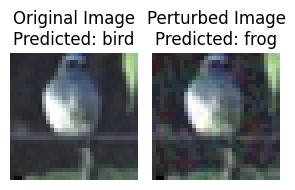

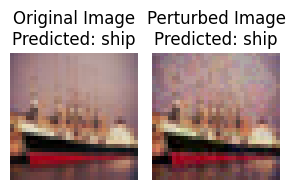

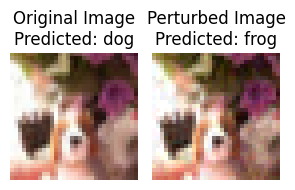

In [16]:
##############################################################################
# Choose 3 random images from testset and run FGSM attack and visualize      #
##############################################################################
import torchattacks
num_samples = len(testset)
random_indices = np.random.choice(num_samples, 3, replace=False)
model.eval()

attack = torchattacks.FGSM(model)
for idx in random_indices:
    image, label = testset[idx]
    label = torch.tensor([label])
    image = image.unsqueeze(0)
    
    image, label = image.to(device), label.to(device)
    adv = attack(image, label)
    pred = model(adv)
    pred = torch.argmax(pred, dim = -1)
    plot_images_with_predictions(image[0].detach().cpu(), adv[0].detach().cpu(), label.detach().cpu().item(), pred.detach().cpu().item())    


################################ End #########################################

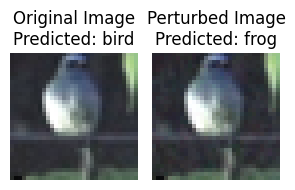

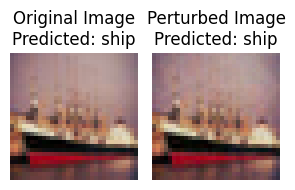

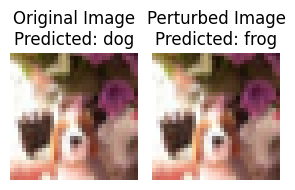

In [17]:
##############################################################################
# Choose 3 random images from testset and run PGD attack and visualize      #
##############################################################################

attack = LinfPGDAttack(model)
for idx in random_indices:
    image, label = testset[idx]
    label = torch.tensor([label])
    image = image.unsqueeze(0)
    
    image, label = image.to(device), label.to(device)
    adv = attack(image, label)
    pred = model(adv)
    pred = torch.argmax(pred, dim = -1)
    plot_images_with_predictions(image[0].detach().cpu(), adv[0].detach().cpu(), label.detach().cpu().item(), pred.detach().cpu().item())    


################################ End #########################################

## Adversarial Training (35 pts)

In this section you are going to adversarially train your model and see the results. 

In [18]:
##############################################################################
# Load a new resnet model for adversarial training                           #
# Train the model on perturbed images from                                   #
# untargeted FGSM attack with epsilon = 8/255 on train dataset               #
# Also use the following setup for training the model                        #
##############################################################################


## instead of training from scratch, I'll train the pretrained model on the new perturbed images

device = 'cuda:0'
model = resnet(len(classes))
# model.load_state_dict(torch.load('./models/resnet18_cifar10_model_pretrained.pth'))
# adv_model = resnet(len(classes))
# adv_model.to(device)
model.to(device)
learning_rate = 0.01
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(adv_model.parameters(), lr=learning_rate, momentum=0.9)
epochs = 80

model_optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)


true = 0

for _ in range(epochs):
    attack = torchattacks.FGSM(model, eps=8/255)
    train_loss = 0
    num_iters = 0
    for data, label in trainloader:
        data, label = data.to(device), label.to(device)

        # output = adv_model(data.clone())
        # loss = criterion(output, label)
        # optimizer.zero_grad()
        # loss.backward()
        # optimizer.step()
        
        adv = attack(data, label)
        output = model(adv.clone())
        loss2 = criterion(output, label)
        model_optimizer.zero_grad()
        loss2.backward()
        model_optimizer.step()

        train_loss += loss2.detach().item() 
        num_iters += 2

    print(f'epoch: {_}, loss: {train_loss/num_iters}')    



################################ End #########################################

epoch: 0, loss: 1.0612043276467287
epoch: 1, loss: 0.9966879570880509
epoch: 2, loss: 0.9640684646108876
epoch: 3, loss: 0.9409045121249031
epoch: 4, loss: 0.9193536204755154
epoch: 5, loss: 0.9020517223021564
epoch: 6, loss: 0.886739683730523
epoch: 7, loss: 0.8692236914659095
epoch: 8, loss: 0.8536195265667518
epoch: 9, loss: 0.8376815082776882
epoch: 10, loss: 0.8206055104884955
epoch: 11, loss: 0.8046394149055871
epoch: 12, loss: 0.7864468789771389
epoch: 13, loss: 0.7697422583694653
epoch: 14, loss: 0.7478562404432565
epoch: 15, loss: 0.7276808813099971
epoch: 16, loss: 0.7079170956026257
epoch: 17, loss: 0.6903377541190828
epoch: 18, loss: 0.6696822239309931
epoch: 19, loss: 0.6502986527464883
epoch: 20, loss: 0.6307233794570883
epoch: 21, loss: 0.6094472598846611
epoch: 22, loss: 0.5890851733477219
epoch: 23, loss: 0.57211546504589
epoch: 24, loss: 0.5525132694360241
epoch: 25, loss: 0.5389863863168165
epoch: 26, loss: 0.5183577124420029
epoch: 27, loss: 0.5006057774014485
epoch

In [19]:
# Save model
model.eval()
model_name = "./models/resnet18_cifar10_model_robust.pth"
model_PATH = f"{model_name}"
torch.save(model.state_dict(), model_PATH)

In [25]:
##############################################################################
# Evaluate the new model on the test dataset                                 #
##############################################################################

model.eval()
with torch.no_grad():
    test_loss = 0
    num_iters = 0
    true = 0
    for data, label in testloader:
        data, label = data.to(device), label.to(device)
        output = model(data)
        
        loss = criterion(output, label)

        test_loss += loss.detach().item()
        num_iters += 1
        pred = torch.argmax(output, dim = -1)


        true += torch.sum((pred.detach().cpu() == label.detach().cpu()).to(int))

    print(true)    
    print(f'accuracy: {true/len(testloader.dataset)}, loss: {test_loss/num_iters}')    

################################ End #########################################

tensor(49561)
accuracy: 0.9912199974060059, loss: 0.038054509143180704


In [21]:
##############################################################################
# Run FGSM attack on the adversarially trained model with epsilon = 8/255    #
##############################################################################

epsilons = [1/255, 4/255, 8/255]
for epsilon in epsilons:
    attack = torchattacks.FGSM(model, eps=epsilon)
    model.eval()

    true = 0
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        adv_images = attack(images, labels)

        with torch.no_grad():
            output = model(adv_images)   
            pred = torch.argmax(output, dim = -1)
            true += torch.sum((pred.detach().cpu() == labels.detach().cpu()).to(int))     

    print(f'epsilon: {epsilon}, acc: {true/len(testloader.dataset)}')

################################ End #########################################

epsilon: 0.00392156862745098, acc: 0.987779974937439
epsilon: 0.01568627450980392, acc: 0.9726399779319763
epsilon: 0.03137254901960784, acc: 0.9247999787330627


In [22]:
##############################################################################
#  Run PGD attack on the adversarially trained model with k=4                #
##############################################################################

batch_num = 10
k_list = [2,4,8]
device = 'cuda:0'
##############################################################################
for kk in k_list:
    attack = LinfPGDAttack(model, k = kk)
    model.to(device)
    model.eval()

    true = 0
    cnt = 0
    for images, labels in testloader:
        cnt += 1
        images, labels = images.to(device), labels.to(device)
        adv_images = attack(images, labels)

        with torch.no_grad():
            output = model(adv_images)   
            pred = torch.argmax(output, dim = -1)
            true += torch.sum((pred.detach().cpu() == labels.detach().cpu()).to(int))     
        if cnt == batch_num:
            break
    print(f'k: {kk}, acc: {true/(10 * batch_size)}')

################################ End #########################################

k: 2, acc: 0.9789062738418579
k: 4, acc: 0.8804687261581421
k: 8, acc: 0.7953125238418579


Answer the following questions:
- What happened to the accuracy of the adversarially trained model?
- What do you conclude from the result of the FGSM attack on the adversarially trained model?
- What do you conclude from the result of the PGD attack on the adversarially trained model?
- What is you final conclusion?

<!DOCTYPE html>
<html lang="en">
<head>
<meta charset="UTF-8">
<meta name="viewport" content="width=device-width, initial-scale=1.0">
<title>Sky Blue Text</title>
<style>
  body {
    font-family: Arial, sans-serif;
    background-color: #f0f8ff; /* Light sky blue background */
    padding: 20px;
  }
  .skyblue-text {
    color: #87ceeb; /* Sky blue color */
  }
</style>
</head>
<body>
  <div class="skyblue-text">
    <p>There was a slight decrease in the performance of the adversarially trained model. It is notable that this model was pretrained on the original samples. Specifically, we should add the pretraining time to the adversarial training time to understand the significant time consumption of this method.

FGSM is not a very strong attack, and the model could be robust against it with sufficient time and training samples.

PGD is a stronger attack and can significantly impact the model's performance.

Depending on our application and timeline, we may invest a substantial amount of time in making our model robust against different attacks, but it could still be vulnerable to new examples. The capacity of our model is another crucial factor. One reason for achieving good results against attacks and experiencing only a minor decrease in performance on the original samples is the high capacity of our model + having a small dataset in a low-dimensional space (3x32x32) (also we can see this through normal model's result on the original test set). In overall we could see the tradeoff between performance and robustness. Also PGD perturbed images was slightly more realistic in the visualized images.

NOTE: I changed the adv model and trained it from scratch instead of using pretrained model to achieve similar results to others.
</p>
  </div>
</body>
</html>